<a href="https://colab.research.google.com/github/laurelkeys/machine-learning/blob/master/assignment-4/Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# # you might want to run this before hand
# # to get prompted a High-RAM notebook option
# d = []
# while True:
#     d.append('1')

## Install dependencies and setup Drive

In [0]:
!pip install PyDrive > /dev/null 2>&1

In [0]:
import os
import zipfile

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

from random import randrange

from gym.envs.atari.atari_env import ACTION_MEANING

from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

## Download and unzip data

In [0]:
# Enable link sharing for the dataset .zip file in your Drive and copy the link:
# https://drive.google.com/open?id=YOUR_FILE_ID

YOUR_FILE_ID = '1OtrZycTx-VItUxzCEVo9lKaBdGk4CyIC'

In [0]:
download = gdrive.CreateFile({'id': YOUR_FILE_ID})

save_folder = "data" # /content/data
os.makedirs(save_folder, exist_ok=True)
download.GetContentFile(os.path.join(save_folder, "atari8.zip"))

In [8]:
!du -sh data/atari8.zip

1.6G	data/atari8.zip


In [0]:
zip_ref = zipfile.ZipFile("/content/data/atari8.zip", 'r')
zip_ref.extractall("/content/data/")
zip_ref.close()

In [0]:
!rm data/atari8.zip

In [11]:
!du -sh data/
!du -sh data/*

3.1G	data/
395M	data/BeamRiderNoFrameskip-v4_PPO2_1000steps
395M	data/BreakoutNoFrameskip-v4_PPO2_1000steps
395M	data/EnduroNoFrameskip-v4_PPO2_1000steps
395M	data/MsPacmanNoFrameskip-v4_PPO2_1000steps
395M	data/PongNoFrameskip-v4_PPO2_1000steps
399M	data/QbertNoFrameskip-v4_PPO2_1000steps
395M	data/SeaquestNoFrameskip-v4_PPO2_1000steps
395M	data/SpaceInvadersNoFrameskip-v4_PPO2_1000steps


In [0]:
GAMES = sorted(os.listdir("data")) # len(GAMES) == 8

In [13]:
print("================")
for i, game_folder in enumerate(GAMES):
    print(game_folder + '/')
    data_folders = sorted([d for d in os.listdir(f"data/{game_folder}")])
    if i == len(GAMES) - 1:
        npz_file_name = [f for f in os.listdir(f"data/{game_folder}/{data_folders[-2]}")
                         if f.endswith('.npz')][0]
        print("├──", data_folders[0] + '/')  # 0
        print("├── ...")
        print("├──", data_folders[-2] + '/') # N_OF_TRAJECTORIES
        print("|   ├──", npz_file_name)      # FILE_NAME
        print("└──", data_folders[-1] + '/') # 'images'
    
    images_folders = sorted([d for d in os.listdir(f"data/{game_folder}/images")])
    if i == len(GAMES) - 1:
        print("    ├──", images_folders[0] + '/')  # 0
        print("    ├── ...")
        print("    └──", images_folders[-1] + '/') # N_OF_TRAJECTORIES
    
    last_images_folder = sorted([d for d in os.listdir(f"data/{game_folder}/images/{images_folders[-1]}")])
    if i == len(GAMES) - 1:
        print("        ├──", last_images_folder[0] + '/')  # 0
        print("        ├── ...")
        print("        └──", last_images_folder[-1] + '/') # N_OF_STEPS

    if i == len(GAMES) - 1:
        print(f"Trajectories: {int(images_folders[-1]) - int(images_folders[0]) + 1}")
        print(f"Steps per trajectory: {int(last_images_folder[-1][:-4]) - int(last_images_folder[0][:-4]) + 1}")
    print("================")

BeamRiderNoFrameskip-v4_PPO2_1000steps/
BreakoutNoFrameskip-v4_PPO2_1000steps/
EnduroNoFrameskip-v4_PPO2_1000steps/
MsPacmanNoFrameskip-v4_PPO2_1000steps/
PongNoFrameskip-v4_PPO2_1000steps/
QbertNoFrameskip-v4_PPO2_1000steps/
SeaquestNoFrameskip-v4_PPO2_1000steps/
SpaceInvadersNoFrameskip-v4_PPO2_1000steps/
├── 00/
├── ...
├── 99/
|   ├── trajectory.npz
└── images/
    ├── 00/
    ├── ...
    └── 99/
        ├── 000.png/
        ├── ...
        └── 999.png/
Trajectories: 100
Steps per trajectory: 1000


## Extract stats from the dataset

In [0]:
# NOTE set these values according to the downloaded dataset
N_OF_TRAJECTORIES = 100
N_OF_STEPS = 1000

FILE_NAME = "trajectory.npz"

In [0]:
stats = { game: { 'cum_reward': [], '1st_ep_len': [], 'actions_pc': [] } for game in GAMES }

In [57]:
for game_folder in GAMES:
    print(game_folder + '/', end=' ')
    for data_folder in os.listdir(f"data/{game_folder}"):
        if data_folder != 'images':
            # 'actions', 'observations', 'rewards', 'episode_starts'
            data = np.load(f"data/{game_folder}/{data_folder}/{FILE_NAME}")
            
            # cumulative reward sum
            stats[game_folder]['cum_reward'].append(np.cumsum(data['rewards']))
            
            # length of the first episode (i.e. steps taken until the first done==True)
            try:
                # remove leading True's
                ep_starts = list(data['episode_starts'])
                first_step = 0
                while ep_starts[first_step]:
                    first_step += 1 
                ep_len = ep_starts[first_step:].index(True) + first_step
            except:
                ep_len = data['episode_starts'].size
            
            stats[game_folder]['1st_ep_len'].append(ep_len)

            # percentage of each action taken
            unique, counts = np.unique(data['actions'], return_counts=True)
            percentages = counts.astype('float') / data['actions'].size
            stats[game_folder]['actions_pc'].append(dict(zip(unique, percentages)))
    
    print("done.")
del data

BeamRiderNoFrameskip-v4_PPO2_1000steps/ done.
BreakoutNoFrameskip-v4_PPO2_1000steps/ done.
EnduroNoFrameskip-v4_PPO2_1000steps/ done.
MsPacmanNoFrameskip-v4_PPO2_1000steps/ done.
PongNoFrameskip-v4_PPO2_1000steps/ done.
QbertNoFrameskip-v4_PPO2_1000steps/ done.
SeaquestNoFrameskip-v4_PPO2_1000steps/ done.
SpaceInvadersNoFrameskip-v4_PPO2_1000steps/ done.


### Actions taken

In [103]:
ACTION_MEANING

{0: 'NOOP',
 1: 'FIRE',
 2: 'UP',
 3: 'RIGHT',
 4: 'LEFT',
 5: 'DOWN',
 6: 'UPRIGHT',
 7: 'UPLEFT',
 8: 'DOWNRIGHT',
 9: 'DOWNLEFT',
 10: 'UPFIRE',
 11: 'RIGHTFIRE',
 12: 'LEFTFIRE',
 13: 'DOWNFIRE',
 14: 'UPRIGHTFIRE',
 15: 'UPLEFTFIRE',
 16: 'DOWNRIGHTFIRE',
 17: 'DOWNLEFTFIRE'}

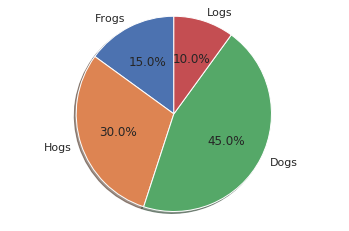

In [102]:
# TODO pie chart with most common actions

### Episode length

In [0]:
def print_1st_ep_len(game_folder):
    v = np.array(stats[game_folder]['1st_ep_len']) # shape == (N_OF_TRAJECTORIES,)
    print("min:", v.min())
    print("max:", v.max())
    print(f"mean: {v.mean():.2f} +- {v.std():.2f} std")

In [94]:
for game_folder in GAMES:
    print(game_folder + '/')
    print_1st_ep_len(game_folder)

BeamRiderNoFrameskip-v4_PPO2_1000steps/
min: 2
max: 1000
mean: 522.72 +- 358.19 std
BreakoutNoFrameskip-v4_PPO2_1000steps/
min: 3
max: 1000
mean: 362.92 +- 394.96 std
EnduroNoFrameskip-v4_PPO2_1000steps/
min: 26
max: 1000
mean: 929.54 +- 202.06 std
MsPacmanNoFrameskip-v4_PPO2_1000steps/
min: 2
max: 603
mean: 199.84 +- 165.73 std
PongNoFrameskip-v4_PPO2_1000steps/
min: 2
max: 1000
mean: 765.43 +- 326.97 std
QbertNoFrameskip-v4_PPO2_1000steps/
min: 10
max: 1000
mean: 298.03 +- 281.21 std
SeaquestNoFrameskip-v4_PPO2_1000steps/
min: 4
max: 566
mean: 270.64 +- 159.27 std
SpaceInvadersNoFrameskip-v4_PPO2_1000steps/
min: 5
max: 906
mean: 262.89 +- 216.86 std


### Cumulative episode reward

In [0]:
def plot_cum_reward(game_folder):
    x = list(range(0, N_OF_STEPS))
    fig, ax = plt.subplots(1, 1, sharex=True)
    ax.set_xlim(0, N_OF_STEPS)

    ax.set_xlabel("steps")
    ax.set_ylabel("cumulative reward sum")

    v = np.array(stats[game_folder]['cum_reward']) # shape == (N_OF_TRAJECTORIES, N_OF_STEPS)
    vavg = v.mean(axis=0)
    vstd = v.std(axis=0)
    vmin = v.min(axis=0)
    vmax = v.max(axis=0)

    ax.set_title(game_folder + '/')
    ax.plot(x, vavg, color=(0, 0.5, 0, 1))
    ax.fill_between(x, vmin, vmax, facecolor='lightgreen', interpolate=True, alpha=0.5)
    ax.plot(x, vavg - vstd, ':', color=(0, 0.5, 0, 0.8))
    ax.plot(x, vavg + vstd, ':', color=(0, 0.5, 0, 0.8))

    plt.show()

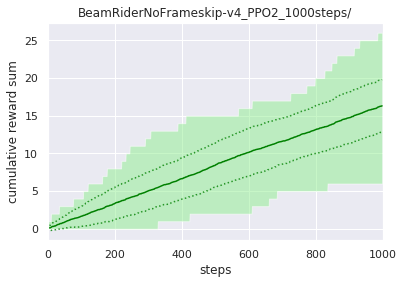

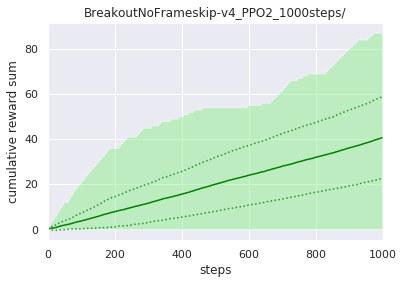

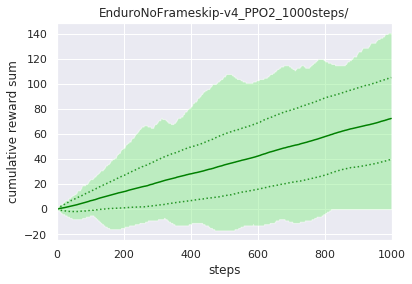

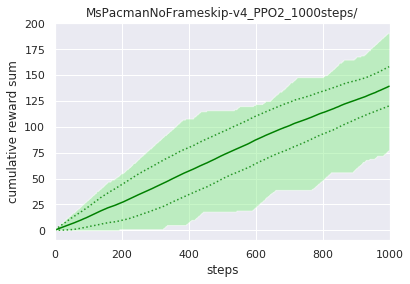

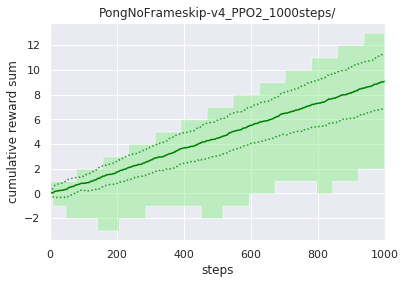

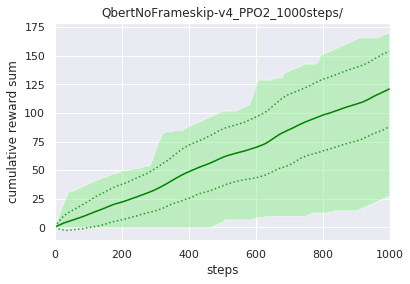

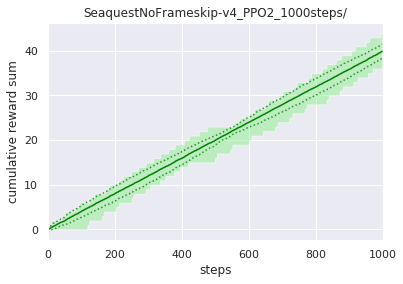

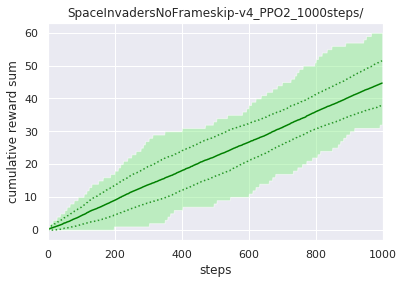

In [87]:
for game_folder in GAMES:
    plot_cum_reward(game_folder)

In [0]:
def print_trajectory_info(x):
    # actions taken
    print("- actions:", x['actions'].shape)
    print("  actions taken:", ', '.join([ACTION_MEANING[action] for action in set(x['actions'].reshape(-1))]))
    # path to the observed images
    print("- observations:", x['observations'].shape)
    print("  path:", os.path.dirname(x['observations'][0]) + '/')
    # reward for each step
    print("- rewards:", x['rewards'].shape)
    print("  reward values:", ', '.join([str(r) for r in set(x['rewards'].reshape(-1))]))
    # `done` value returned by env.step(action)
    print("- episode_starts:", x['episode_starts'].shape)
    print("  episode starts:", [i for i, ep_start in enumerate(x['episode_starts']) if ep_start])

In [0]:
print_trajectory_info(x)